# Sparse Inverse Covariance Estimation

**References:**
1. S. Boyd and L. Vandenberghe. Chapter 7.1.1 in [*Convex Optimization.*](https://web.stanford.edu/~boyd/cvxbook/) Cambridge University Press, 2004.
2. O. Bannerjee, L. E. Ghaoui, and A. d'Aspremont. [*Model Selection Through Sparse Maximum Likelihood Estimation for Multivariate Gaussian or Binary Data.*](http://www.jmlr.org/papers/volume9/banerjee08a/banerjee08a.pdf) Journal of Machine Learning Research, 9(1):485-516, 2008.
3. J. Friedman, T. Hastie, and R. Tibshirani. [*Sparse Inverse Covariance Estimation with the Graphical Lasso.*](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3019769/) Biostatistics, 9(3):432-441, 2008.

## Introduction

Suppose $z \in \mathbf{R}^q$ is a Gaussian random variable with mean zero and covariance matrix $\Sigma$, where $\Sigma^{-1}$ 
is known to be sparse. (This implies that many pairs of elements in $z$ are conditionally independent). We want to estimate the covariance matrix based on samples $z_1,\ldots,z_p$ drawn independently from $N(0,\Sigma)$.

A good heuristic for estimating $\Sigma$ is to solve the problem

$$\text{minimize}~ -\log\det(S) + \text{tr}(SQ) + \alpha\|S\|_1$$

with respect to $S \in \mathbf{S}^q$ (the set of symmetric matrices), where $Q = \frac{1}{p}\sum_{l=1}^p z_lz_l^T$ is the sample covariance and $\alpha > 0$ is a sparsity parameter. Here $\log\det$ is understood to be an extended real-valued function, so that $\log\det(S) = -\infty$ whenever $S$ is not positive definite.

If $S^*$ is the solution to this problem, we take our estimate of the covariance matrix to be $\hat \Sigma = (S^*)^{-1}$.

## Reformulate Problem

Let $x_i \in \mathbf{R}^{q(q+1)/2}$ be a vectorization of $S_i \in \mathbf{S}^q$ for $i = 1,2$. For instance, $x_i$ could be the lower triangular elements of $S_i$ taken in column order. The sparse inverse covariance estimation problem can be written in standard form by setting

$$f_1(x_1) = -\log\det(S_1) + \text{tr}(S_1Q), \quad f_2(x_2) = \alpha\|S_2\|_1,$$

where it is implicit that $x_i$ is reshaped into $S_i$. Notice that we have grouped the $\log\det$ term with the matrix trace term. This is because $\text{tr}(S_1Q)$ is an affine function, so we can apply the affine addition rule to evaluate $\mathbf{prox}_{tf_1}$ using $\mathbf{prox}_{t\log\det(\cdot)}$. See Sections 2.2 and 6.7.5 of [N. Parikh and S. Boyd (2013)](https://web.stanford.edu/~boyd/papers/prox_algs.html).

## Generate Data

We generate $S$ randomly from the set of symmetric positive definite matrices with $q = 20$ and about 10% nonzero entries. Then, we compute $Q$ using $p = 1000$ IID samples drawn from $N(0,S^{-1})$.

In [8]:
import numpy as np
import scipy as sp
from scipy import sparse
from sklearn.datasets import make_sparse_spd_matrix
from a2dr import a2dr
from a2dr.proximal import *

np.random.seed(1)

# Problem data.
q = 20
p = 1000
nnz_ratio = 0.1   # Fraction of nonzeros in S.

# Create sparse symmetric PSD matrix S.
S_true = sparse.csc_matrix(make_sparse_spd_matrix(q,1-nnz_ratio))

# Create covariance matrix associated with S.
Sigma = sparse.linalg.inv(S_true).todense()

# Draw samples from the Gaussian distribution with covariance Sigma.
z_sample = sp.linalg.sqrtm(Sigma).dot(np.random.randn(q,p))
Q = np.cov(z_sample)

## Solve Problem for Several $\alpha$ Values

In [47]:
# Calculate smallest alpha for which solution is trivially
# the diagonal matrix (diag(Q) + alpha*I)^{-1}.
# Reference: O. Bannerjee, L. E. Ghaoui, and A. d'Aspremont (2008).
mask = np.ones(Q.shape, dtype=bool)
np.fill_diagonal(mask, 0)
alpha_max = np.max(np.abs(Q)[mask])

# The alpha values for each attempt at generating S.
alpha_ratios = np.array([1, 0.1, 0.01])
alphas = alpha_ratios*alpha_max

# Empty list of result matrices S.
Ss = []

# Solve for the problem for each value of alpha.
for alpha in alphas:
    # Convert problem to standard form.
    prox_list = [lambda v, t: prox_neg_log_det(v.reshape((q,q), order='C'), t, lin_term=t*Q).ravel(order='C'), 
                 lambda v, t: prox_norm1(v, t*alpha)]
    A_list = [sparse.eye(q*q), -sparse.eye(q*q)]
    b = np.zeros(q*q)
    
    # Solve with A2DR.
    a2dr_result = a2dr(prox_list, A_list, b)
    a2dr_S = a2dr_result["x_vals"][-1].reshape((q,q), order='C')
    
    # Threshold S element values to enforce exact zeroes.
    S_thres = a2dr_S
    S_thres[np.abs(S_thres) <= 1e-4] = 0
    
    # Store thresholded S for later visualization.
    Ss += [S_thres]
    
    print("Solved optimization problem with alpha =", alpha)

### Preconditioning starts ...
Block matrix shape = (400, 2)
gamma=7.487833499908446e-09
k=0, err_d=7.487833353359008e-09, err_e=5.6621374255882976e-15
generate D, E
compute scaled matrix
After preconditioning, t_init changed to 1.9999999999999996
Iteration: 0
Iteration: 10
Iteration: 20
Solved optimization problem with alpha = 1.1847682358887528
### Preconditioning starts ...
Block matrix shape = (400, 2)
gamma=7.487833499908446e-09
k=0, err_d=7.487833353359008e-09, err_e=5.6621374255882976e-15
generate D, E
compute scaled matrix
After preconditioning, t_init changed to 1.9999999999999996
Iteration: 0
Iteration: 10
Iteration: 20
Iteration: 30
Iteration: 40
Iteration: 50
Iteration: 60
Iteration: 70
Iteration: 80
Solved optimization problem with alpha = 0.11847682358887529
### Preconditioning starts ...
Block matrix shape = (400, 2)
gamma=7.487833499908446e-09
k=0, err_d=7.487833353359008e-09, err_e=5.6621374255882976e-15
generate D, E
compute scaled matrix
After preconditioning, t_init

## Plot Resulting Sparsity Patterns

<Figure size 432x288 with 0 Axes>

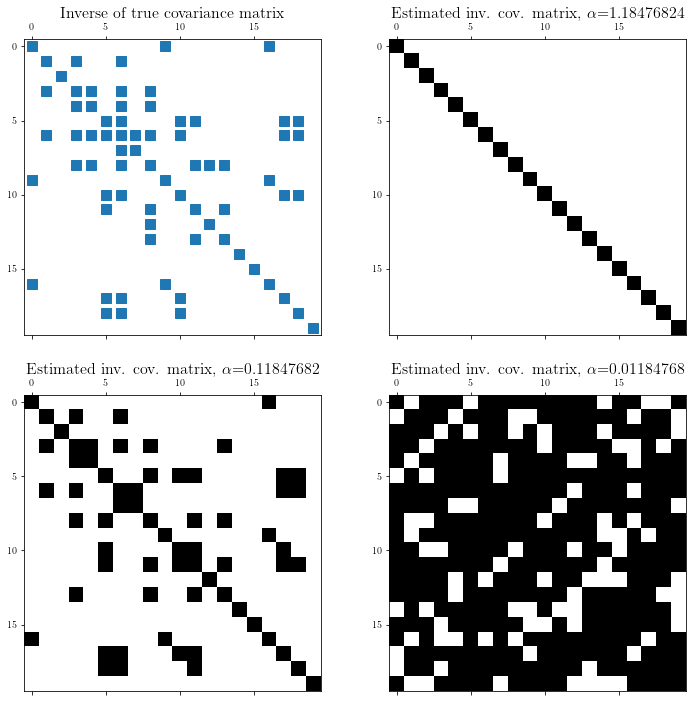

In [45]:
import matplotlib.pyplot as plt

# Show plot inline in ipython.
%matplotlib inline

# Plot properties.
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

# Create figure.
plt.figure()
plt.figure(figsize=(12, 12))

# Plot sparsity pattern for the true covariance matrix.
plt.subplot(2, 2, 1)
plt.spy(S_true)
plt.title('Inverse of true covariance matrix', fontsize=16)

# Plot sparsity pattern for each result, corresponding to a specific alpha.
for i in range(len(alphas)):
    plt.subplot(2, 2, 2+i)
    plt.spy(Ss[i])
    plt.title('Estimated inv. cov. matrix, $\\alpha$={0:.8f}'.format(alphas[i]), fontsize=16)